In [2]:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization 
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_14464\1994942180.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

In [17]:
wine_df = pd.read_csv(url, sep=';')
wine_df = wine_df[wine_df['total sulfur dioxide']<200]

In [18]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [19]:
# z-score all columns except for quality
cols2zscore = wine_df.columns.drop('quality')
wine_df[cols2zscore] = wine_df[cols2zscore].apply(stats.zscore)

In [21]:
# create new column for binarized quality
wine_df['boolQuality'] = 0
wine_df.loc[wine_df['quality'] > 5, 'boolQuality'] = 1

# Re-orgnize the data into train/test in Dataloaders

In [23]:
# convert from pandas dataframe to tensor
dataTensor = torch.tensor(wine_df[cols2zscore].values, dtype=torch.float32)
labelTensor = torch.tensor(wine_df['boolQuality'].values, dtype=torch.float32)
labelTensor = labelTensor[:, None]

In [24]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataTensor, labelTensor, test_size=0.2, random_state=42)

In [25]:
# then convert them into PyTorch datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

In [27]:
# train and test data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [28]:
# create class for the model with batch-normalization

class WineModel_BNorm(nn.Module):

    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11, 16)

        # hidden layers
        self.fc1 = nn.Linear(16, 32) # fc means fully connected
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32, 20)
        self.bnorm2 = nn.BatchNorm1d(32)

        # output layer
        self.output = nn.Linear(20, 1)

    # forward pass
    def forward(self, x,doBN):
      
      x = F.relu(self.input(x)) # no batch normalization for input layer

      if doBN:
        # hidden layer 1
        x = self.bnorm1(x) # batch normalization
        x = self.fc1(x) # weighted combination
        x = F.relu(x) # activation function

        # hidden layer 2

        x = self.bnorm2(x) 
        x = self.fc2(x)
        x = F.relu(x)

      else:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  

      return self.output(x)    

# Train the model

In [39]:
# a function to train the model
# global parameters
num_epochs = 1000

def trainTheM0del(doBN=True,model=WineModel_BNorm()):

    # loss function and optimizer
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)

    # initialize losses
    losses = torch.zeros(num_epochs)
    train_accuracy = []
    test_accuracy = []

    # loop over epochs
    
    for epoch in range(num_epochs):
        #switch to train mode
        model.train()

        # loop over training data in batches
        batch_accuracy = []
        batch_loss = []
        for X, y in train_loader:
            # forward pass and loss
            y_pred = model(X,doBN)
            loss = loss_function(y_pred, y)
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batch_loss.append(loss.item())

            # compute accuracy for this batch
            batch_accuracy.append(100*torch.mean(((y_pred > .5) == y).float()).item())
        # end of batch loop
        # compute average accuracy and loss for this epoch
        train_accuracy.append(np.mean(batch_accuracy))
        losses[epoch] = np.mean(batch_loss)

        # test accuracy
        model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            y_pred = model(X,doBN)
        test_accuracy.append(100*torch.mean(((y_pred > .5) == y).float()).item())

    return losses, train_accuracy, test_accuracy    

# The experiment

In [40]:
# train the model without batch normalization
model = WineModel_BNorm()
lossesNo, train_accuracyNo, test_accuracyNo = trainTheM0del(False,model)

In [41]:
# train the model with batch normalization
model = WineModel_BNorm()
lossesYes, train_accuracyYes, test_accuracyYes = trainTheM0del(True,model)

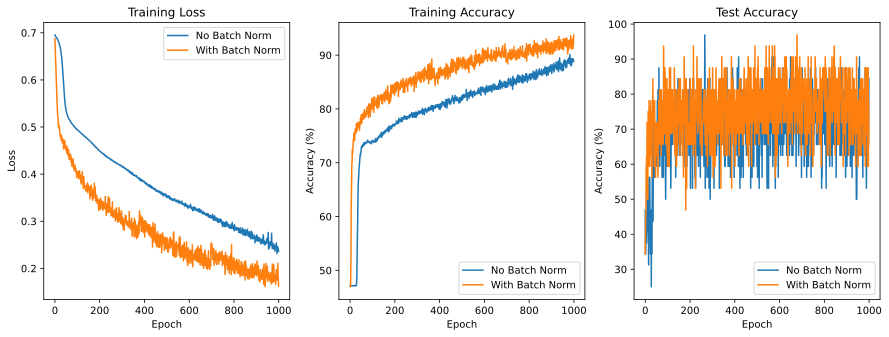

In [42]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(lossesNo,label='No Batch Norm')
ax[0].plot(lossesYes,label='With Batch Norm')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracyNo,label='No Batch Norm')  
ax[1].plot(train_accuracyYes,label='With Batch Norm')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].set_title('Training Accuracy')

ax[2].plot(test_accuracyNo,label='No Batch Norm')
ax[2].plot(test_accuracyYes,label='With Batch Norm')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy (%)')
ax[2].legend()
ax[2].set_title('Test Accuracy')

plt.show()